In [1]:
import sys
import os
import os.path as osp
import pandas as pd

import torch
sys.path.insert(1, osp.abspath('../'))
torch.cuda.empty_cache()

In [2]:
exp_11 = "979156837763893073"
exp_8 = "454575397835495809"
exp_10 = "246461092875715692"
exp_9 = "244926936006304990"

In [3]:
import yaml
runs = os.listdir("/home/hmv/tfm/mcmt_gnn/mlruns/454575397835495809/")
runs.remove("meta.yaml")
runs.remove("tags")
run_name = None
for run in runs:
    run_path = osp.join("/home/hmv/tfm/mcmt_gnn/mlruns/454575397835495809/", run)
    with open(osp.join(run_path, "meta.yaml"), 'r') as meta:
        
        yaml_file = yaml.safe_load(meta)
        if yaml_file["run_name"] == "tuning_block_8_v3_trial_778_500":
            run_name = yaml_file["run_name"]
            preds_prob = pd.read_json(osp.join(run_path, "artifacts", "prediction_scores.txt"),  orient="split")
            preds_prob = torch.tensor(preds_prob.values)

In [4]:
from modules.torch_dataset.object_graph_reid_precomp import ObjectGraphREIDPrecompDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import torch_geometric.transforms as T

val_dataset = ObjectGraphREIDPrecompDataset(sequence_path_prefix="/home/hmv/tfm/mcmt_gnn/datasets/AIC20",
                                            sequence_names=["S02"],
                                            annotations_filename="mtsc_tnt_ssd512_roi_filtered.txt",
                                            num_ids_per_graph=-1,
                                            return_dataframes=True,
                                            graph_transform=T.ToUndirected())

graph, node_df, edge_df = val_dataset[0]


# Start the multi-camera association
data_df = AnnotationsProcessor(sequence_path="/home/hmv/tfm/mcmt_gnn/datasets/AIC20", 
                            annotations_filename="mtsc_tnt_ssd512_roi_filtered.txt")\
                            .consolidate_annotations(["S02"], ["frame", "camera"])

gt_df = AnnotationsProcessor(sequence_path="/home/hmv/tfm/mcmt_gnn/datasets/AIC20", 
                            annotations_filename="gt_roi_filtered.txt")\
                            .consolidate_annotations(["S02"], ["frame", "camera"])

In [5]:
from modules.inference.postprocessing import postprocessing, remove_dets_with_one_camera
from modules.inference.preprocessing import filter_dets_outside_frame_bounds
predictions = torch.argmax(preds_prob, dim=1).cpu()

edge_list = graph.edge_index.cpu().numpy()

# Connected components output
id_pred, predictions = postprocessing(4, 
                                        preds_prob,
                                        predictions,
                                        edge_list,
                                        graph.cpu(),
                                        True,
                                        False,
                                        False,
                                        False)

# Add old IDs as separate column to inspect
data_df['id_old'] = data_df.id

# Generate tracking dataframe
for n in range(len(graph.x)):
    id_new = int(id_pred[n])
    cam_id = node_df.camera[n]
    id_old = node_df.object_id[n]

    # Assign the labels from the connected components to the detections df
    data_df.loc[(data_df['id_old'] == id_old) & 
                    (data_df['camera'] == cam_id),'id'] = id_new

# If required, remove detections that go beyond the frame limits

data_df = filter_dets_outside_frame_bounds(data_df, 
                                            1920, 
                                            1080)
gt_df = filter_dets_outside_frame_bounds(gt_df, 
                                        1920, 
                                        1080)

# This is only for the single camera tracking estimates, not gorund truth
data_df = remove_dets_with_one_camera(data_df)

/home/hmv/tfm/mcmt_gnn/modules/inference/postprocessing.py:347: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return id_pred, torch.tensor(whole_edges_prediction)


In [6]:
from modules.inference.postprocessing import fix_annotation_frames
import motmetrics as mm

data_df.camera = data_df.camera.apply(lambda cam: int(cam.replace('c', '')))
gt_df.camera = gt_df.camera.apply(lambda cam: int(cam.replace('c', '')))

# Avoid colisions in the frame index
gt_df, pred_df = fix_annotation_frames(gt_df, data_df)

# Setting column names as motmetrics requires it
gt_df = gt_df.rename(columns={'frame': 'FrameId',
                                'xmin': 'X', 
                                'ymin': 'Y', 
                                'width': 'Width', 
                                'height': 'Height',
                                'id': 'Id'})

pred_df = pred_df.rename(columns={'frame': 'FrameId',
                                'xmin': 'X', 
                                'ymin': 'Y', 
                                'width': 'Width', 
                                'height': 'Height',
                                'id': 'Id'})

# Setting frame id and id as index since motmetrics requires it
gt_df = gt_df.set_index(['FrameId', 'Id'])
pred_df = pred_df.set_index(['FrameId', 'Id'])

# Compute metrics using Pymotmetrics
mh = mm.metrics.create()
accumulator = mm.utils.compare_to_groundtruth(gt_df, pred_df, 'iou', distth=0.8)
metrics=[*mm.metrics.motchallenge_metrics, *['num_frames','idfp','idfn','idtp']]
summary = mh.compute(accumulator, metrics=metrics, name='MultiCam')

[6 7 8 9] [6 7 8 9]


In [7]:
summary

,idf1,idp,idr,recall,precision,num_unique_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,...,num_fragmentations,mota,motp,num_transfer,num_ascend,num_migrate,num_frames,idfp,idfn,idtp
MultiCam,0.789889,0.727053,0.870437,0.941767,0.782234,145,132,9,4,4984,...,77,0.679064,0.470899,50,1,23,7647,6212.0,2463.0,16547.0


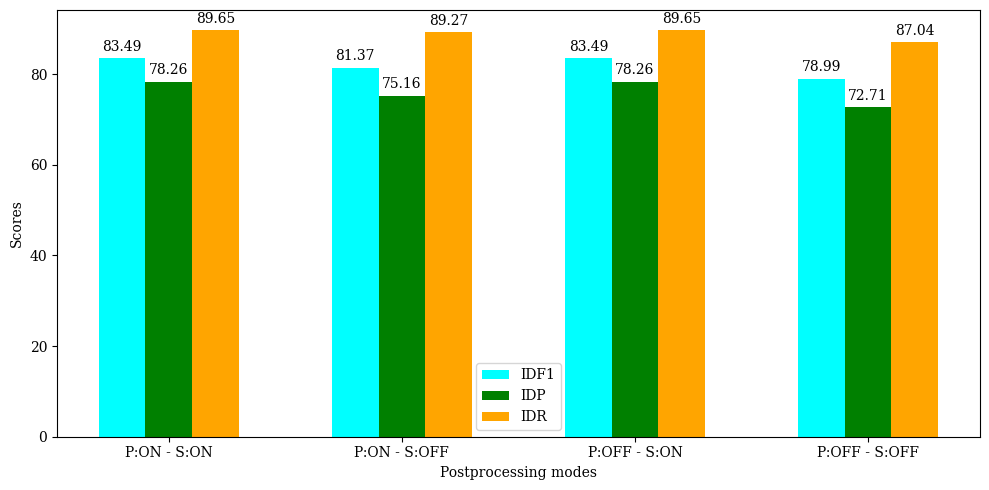

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from matplotlib import rcParams

# Use a built-in font similar to LaTeX
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']


plt.figure(figsize=(10, 5))
# create data 
x = np.arange(4) 
on_on = [83.49, 78.26, 89.65] 
on_off = [81.37, 75.16, 89.27]
off_on = [83.49, 78.26, 89.65] 
off_off = [78.99, 72.71, 87.04]

scores = np.array([on_on, on_off, off_on, off_off]).T
width = 0.2
  
# plot data in grouped manner of bar type 
plt.bar(x-0.2, scores[0], width, color='cyan') 
plt.bar(x, scores[1], width, color='green') 
plt.bar(x+0.2, scores[2], width, color='orange') 

# Annotate the bars with their values
for i in range(len(x)):
    plt.text(x[i] - 0.2, scores[0, i] + 1, str(scores[0, i]), ha='center', va='bottom', color='black')
    plt.text(x[i], scores[1, i] + 1, str(scores[1, i]), ha='center', va='bottom', color='black')
    plt.text(x[i] + 0.2, scores[2, i] + 1, str(scores[2, i]), ha='center', va='bottom', color='black')


plt.xticks(x, ['P:ON - S:ON', 'P:ON - S:OFF', 'P:OFF - S:ON', 'P:OFF - S:OFF']) 
plt.xlabel("Postprocessing modes") 
plt.ylabel("Scores") 
plt.legend(["IDF1", "IDP", "IDR"]) 
plt.tight_layout()
plt.show() 